## 0. Setup

In [3]:
# Load Packages
import os, sys, inspect
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
%matplotlib inline
import matplotlib.pylab as plt

# Show all columns when printing the head of the dataframe
pd.set_option('display.max_columns', None)

# Define working directory
os.chdir("/Users/jonaswallstein/Documents/GitHub/CML/CML_materials/utils")
from helper_functions import *

## 1. Preprocessing Data

### 1.1 Load Data

In [4]:
# Load train, test and meta data
data_train = pd.read_csv("../Data/cml23-probability-of-death-with-k-nn/mimic_train.csv")
data_test = pd.read_csv("../Data/cml23-probability-of-death-with-k-nn/mimic_test_death.csv")
diagnosis_data = pd.read_csv("../Data/cml23-probability-of-death-with-k-nn/extra_data/MIMIC_diagnoses.csv")
diagnosis_description = pd.read_csv("../Data/cml23-probability-of-death-with-k-nn/MIMIC_metadata_diagnose.csv")

# Sort the values in the test data by icustay_id to match the Sample output prediction file
data_test = data_test.sort_values('icustay_id')
# print head of the test dataset
data_test.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,84.0,59.911765,60.0,109.0,83.861111,18.0,34.0,26.976190,36.444444,37.666667,37.005556,89.0,100.0,95.605263,94.0,108.0,101.000000,F,2104-05-13 00:00:00,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.000000,F,2053-08-08 00:00:00,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,80.0,43.363636,49.0,88.0,59.848485,11.0,27.0,18.861111,36.444444,37.388889,36.816667,88.0,100.0,96.027778,125.0,297.0,199.875000,M,2054-03-21 00:00:00,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,64.0,53.707317,14.0,83.0,68.826667,9.0,22.0,17.291667,NaN,NaN,NaN,87.0,100.0,96.837209,95.0,196.0,127.368421,M,2104-02-12 00:00:00,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,91.0,64.281250,57.0,97.0,75.343750,9.0,28.0,21.029412,35.555556,38.888889,37.489899,92.0,100.0,95.617647,81.0,134.0,117.833333,M,2072-04-09 00:00:00,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [5]:
# Sample output prediction file
pred_sample=pd.read_csv('../Data/cml23-probability-of-death-with-k-nn/mimic_kaggle_death_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
1937,200011,0
4908,200044,0
829,200049,0
4378,200063,0
4946,200081,0


### 1.2 Merge Meta Data

In [6]:
# Changing coumns names to facilitate merging with train and test data
diagnosis_data = diagnosis_data.rename(columns = {'ICD9_CODE' : 'ICD9_diagnosis', 'SUBJECT_ID' : 'subject_id', 'HADM_ID' : 'hadm_id'})
print(diagnosis_data.head())

   subject_id  hadm_id  SEQ_NUM ICD9_diagnosis
0         256   108811      1.0          53240
1         256   108811      2.0          41071
2         256   108811      3.0          53560
3         256   108811      4.0          40390
4         256   108811      5.0           5859


Check whether first column for each subject_id hadm_id pair in the meta data corresponds to the ICD9_diagnosis in our train/test data

In [7]:
diagnosis_check = diagnosis_data.query("SEQ_NUM == 1")
diagnosis_check = diagnosis_check[["subject_id", "hadm_id", "ICD9_diagnosis"]]

data_train_check = pd.merge(data_train, diagnosis_check, how = "left", on = ["subject_id", "hadm_id"])
data_test_check = pd.merge(data_test, diagnosis_check, how = "left", on = ["subject_id", "hadm_id"])

# Check if 'ICD9_diagnosis_x' and 'ICD9_diagnosis_y' are equal
if (data_train_check['ICD9_diagnosis_x'] == data_train_check['ICD9_diagnosis_y']).all():
    print("The columns are equal.")
else:
    print("The columns are not equal.")
    
if (data_test_check['ICD9_diagnosis_x'] == data_test_check['ICD9_diagnosis_y']).all():
    print("The columns are equal.")
else:
    print("The columns are not equal.")

The columns are equal.
The columns are equal.


This verifies that the ICD9_diagnosis in the train/test data corresponds to the rows with SEQ_NUM equal to 1 in the meta data. Further, the Diagnosis column in the main data is just a list of all diagnoses of a patient for a given hospital visit, which is also contained in the meta data. Thus, all information in the columns ICD9_diagnosis and Diagnosis are given (more precisely) in the meta data and these columns can be discarded. 

The idea is now to merge the variable HOSPITAL_EXPIRE_FLAG to the meta data and then group by the diagnosis to calculate the mean death probability for each diagnosis (based on the trianing data). This gives a more precise death probability than simply target encoding the ICD9_diagnosis. The reason is that a patient might have died because of the third diagnosis that was listed for the visit, but only the main diagnosis is recorded in the ICD9_variable. 
If the main diagnosis is not the actual reason a patient died, mean target encoding yields a distorted picture over which diagnoses have the highest death probability and leads to overfitting.

In [8]:
data_train_short = data_train[["subject_id", "hadm_id", "HOSPITAL_EXPIRE_FLAG"]]
diagnosis_prob = pd.merge(diagnosis_data, data_train_short, how = "left", on = ["subject_id", "hadm_id"])
diagnosis_prob.head()
death_prob = diagnosis_prob.groupby('ICD9_diagnosis').agg({'HOSPITAL_EXPIRE_FLAG' : 'mean'})
death_prob = death_prob.rename(columns = {'HOSPITAL_EXPIRE_FLAG' : 'death_probability'})

diagnosis_prob = pd.merge(diagnosis_prob, death_prob, how = "left", on = "ICD9_diagnosis")
# diagnosis_prob['death_probability'] =  diagnosis_prob['death_probability'].fillna(0)
diagnosis_prob_wide = pd.DataFrame(diagnosis_prob.pivot_table(index = ["subject_id", "hadm_id"], columns = "SEQ_NUM", values = "death_probability"))
# print(diagnosis_prob_wide.head(20))

Thus, after calculating the mean death probability for each diagnosis, I know have a list of the death probabilities for each of the patient's diagnoses during a visit. This can be up to 39 different diagnoses. Including those as separate columns for each patient would more than double the amount of columns which could lead to overfitting on the training data and additionally could overweigh the importance of the diagnosis. Hence, I summarised these column by using the mean, max and the sum of those death probabilities for each patient visit. The mean gives an average severness of the recorded diagnoses, the max gives the "most deadly" and the sum gives the additive effet of all diagnoses combined. This approach reduces the amount of variables drastically and gives a reasonable weight (of 3 columns) to the diagnoses. Yet, reducing the variance in the diagnoses to those summary statisics likely preserves a large portion of the variance and allows to differentiate between high and low severness.

In [9]:
column_names = diagnosis_prob_wide.columns.tolist()
columns_to_mean = [col for col in column_names if isinstance(col, float) and 1.0 <= col <= 39.0]
# print(columns_to_mean)
# Select the columns and calculate the mean, ignoring NaN values with skipna=True
diagnosis_prob_wide['mean_death_prob'] = diagnosis_prob_wide[columns_to_mean].mean(axis=1, skipna=True)
diagnosis_prob_wide['max_death_prob'] = diagnosis_prob_wide[columns_to_mean].max(axis=1, skipna=True)
diagnosis_prob_wide['sum_death_prob'] = diagnosis_prob_wide[columns_to_mean].sum(axis=1, skipna=True)
diagnosis_prob_wide = diagnosis_prob_wide.drop(columns_to_mean, axis = 1)
diagnosis_prob_wide.head()

,SEQ_NUM,mean_death_prob,max_death_prob,sum_death_prob
subject_id,hadm_id,,,
2,163353,0.000000,0.000000,0.000000
3,145834,0.231113,0.534290,2.080021
4,185777,0.164449,0.327869,1.480037
5,178980,0.000000,0.000000,0.000000
6,107064,0.137626,0.207607,1.101007


Now, I merge these 3 summary statistics back to the train and test data.

In [10]:
data_train = pd.merge(data_train, diagnosis_prob_wide, how = "left", on = ["subject_id", "hadm_id"])
data_test = pd.merge(data_test, diagnosis_prob_wide, how = "left", on = ["subject_id", "hadm_id"])
data_train = data_train.drop("ICD9_diagnosis", axis = 1)
data_test = data_test.drop("ICD9_diagnosis", axis = 1)
data_test.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,FIRST_CAREUNIT,mean_death_prob,max_death_prob,sum_death_prob
0,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,84.0,59.911765,60.0,109.0,83.861111,18.0,34.0,26.976190,36.444444,37.666667,37.005556,89.0,100.0,95.605263,94.0,108.0,101.000000,F,2104-05-13 00:00:00,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,MICU,0.117247,0.240741,1.524212
1,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.000000,F,2053-08-08 00:00:00,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,SICU,0.173420,0.350000,0.867099
2,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,80.0,43.363636,49.0,88.0,59.848485,11.0,27.0,18.861111,36.444444,37.388889,36.816667,88.0,100.0,96.027778,125.0,297.0,199.875000,M,2054-03-21 00:00:00,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,MICU,0.160134,0.417178,4.003341
3,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,64.0,53.707317,14.0,83.0,68.826667,9.0,22.0,17.291667,NaN,NaN,NaN,87.0,100.0,96.837209,95.0,196.0,127.368421,M,2104-02-12 00:00:00,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,CSRU,0.183219,0.362482,3.297951
4,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,91.0,64.281250,57.0,97.0,75.343750,9.0,28.0,21.029412,35.555556,38.888889,37.489899,92.0,100.0,95.617647,81.0,134.0,117.833333,M,2072-04-09 00:00:00,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,CCU,0.130594,0.208161,1.567122


### 1.3 Define X and y and inspect the Data

Define X_train, X_test and y_train

In [11]:
# Define X_train and y_train
#X_train = data_train.copy()
X_train = data_train.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)
y_train = data_train['HOSPITAL_EXPIRE_FLAG']

# Drop ID variables from X_train
X_train = X_train.drop(['subject_id','hadm_id','icustay_id'], axis = 1)

# Define X_test and y_test
X_test = data_test.copy()

# Drop ID variables from X_test
X_test = X_test.drop(['subject_id','hadm_id','icustay_id'], axis = 1)
#y_test = data_test['class']
X_test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,FIRST_CAREUNIT,mean_death_prob,max_death_prob,sum_death_prob
0,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,84.0,59.911765,60.0,109.0,83.861111,18.0,34.0,26.976190,36.444444,37.666667,37.005556,89.0,100.0,95.605263,94.0,108.0,101.000000,F,2104-05-13 00:00:00,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,MICU,0.117247,0.240741,1.524212
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.000000,F,2053-08-08 00:00:00,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,SICU,0.173420,0.350000,0.867099
2,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,80.0,43.363636,49.0,88.0,59.848485,11.0,27.0,18.861111,36.444444,37.388889,36.816667,88.0,100.0,96.027778,125.0,297.0,199.875000,M,2054-03-21 00:00:00,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,MICU,0.160134,0.417178,4.003341
3,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,64.0,53.707317,14.0,83.0,68.826667,9.0,22.0,17.291667,NaN,NaN,NaN,87.0,100.0,96.837209,95.0,196.0,127.368421,M,2104-02-12 00:00:00,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,CSRU,0.183219,0.362482,3.297951
4,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,91.0,64.281250,57.0,97.0,75.343750,9.0,28.0,21.029412,35.555556,38.888889,37.489899,92.0,100.0,95.617647,81.0,134.0,117.833333,M,2072-04-09 00:00:00,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,CCU,0.130594,0.208161,1.567122


Inspect the Data

In [12]:
# Inspect training data
print(X_train.shape) # to get dimensions of the numpy array
X_train.describe()

(20885, 42)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS,mean_death_prob,max_death_prob,sum_death_prob
count,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,18676.000000,18676.000000,18699.000000,18699.000000,18699.000000,18696.000000,18696.000000,18696.000000,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000
mean,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,88.360784,62.511614,56.293064,107.074282,77.609535,11.919207,27.780220,18.985855,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046,0.135562,0.300495,2.100168
std,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,19.285554,11.010790,14.348780,27.585990,11.113299,3.572189,6.278514,3.849713,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721,0.045018,0.152907,1.386077
min,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,1.000000,29.000000,25.759907,1.000000,12.000000,9.291667,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600,0.000000,0.000000,0.000000
25%,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,75.000000,54.950952,49.000000,91.000000,70.033908,10.000000,23.000000,16.250000,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400,0.106071,0.194805,1.095666
50%,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,86.000000,61.423660,57.000000,102.000000,76.294118,12.000000,27.000000,18.382353,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800,0.128230,0.263636,1.798269
75%,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,98.000000,68.954545,64.000000,116.000000,84.041774,14.000000,31.000000,21.105543,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800,0.158032,0.362482,2.752142
max,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,294.000000,121.489362,122.000000,299.000000,136.652174,31.000000,69.000000,41.235294,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000,0.701144,1.000000,10.240492


In [13]:
# Inspect test data
print(X_test.shape) # to get dimensions of the numpy array
X_test.describe()

(5221, 38)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,mean_death_prob,max_death_prob,sum_death_prob
count,4676.000000,4676.000000,4676.000000,4670.000000,4670.000000,4670.000000,4669.000000,4669.000000,4669.000000,4674.000000,4674.000000,4674.000000,4675.000000,4675.000000,4675.000000,4583.000000,4583.000000,4583.000000,4670.000000,4670.000000,4670.000000,5163.000000,5163.000000,5163.000000,5221.000000,5221.000000,5221.000000,5221.000000
mean,69.942686,105.279940,85.221128,90.862392,150.547966,118.763143,44.142643,88.177982,62.216431,55.973220,107.157467,77.246222,11.963422,27.747807,19.050812,36.041879,37.441470,36.755418,90.828480,99.553319,96.857538,107.823494,376.578346,163.521697,-51606.334303,0.136742,0.302575,2.077123
std,15.013524,21.247956,15.484126,17.529140,23.575450,16.490767,11.695481,19.798920,11.007798,14.423692,28.515073,11.009335,3.563914,6.265139,3.843275,0.762967,0.797153,0.595941,7.660437,1.516541,2.406957,34.312518,13915.510710,1739.829727,10666.881712,0.043598,0.151614,1.336602
min,1.000000,42.000000,36.000000,10.000000,62.000000,51.750000,6.000000,31.000000,24.250000,0.830000,39.000000,30.250000,1.000000,12.000000,9.875000,22.777778,32.555556,32.222222,1.000000,42.000000,42.000000,15.000000,32.000000,32.000000,-72639.620300,0.000000,0.000000,0.000000
25%,60.000000,90.000000,74.035131,81.000000,134.000000,106.752976,37.000000,75.000000,54.714286,49.000000,91.000000,69.751524,10.000000,23.000000,16.390244,35.666667,36.944444,36.409722,90.000000,100.000000,95.840227,87.000000,126.000000,111.500000,-60840.730090,0.107393,0.194805,1.102491
50%,69.000000,104.000000,83.957428,90.000000,148.000000,116.807407,44.000000,85.000000,61.060606,57.000000,102.000000,76.098785,12.000000,27.000000,18.347826,36.111111,37.333333,36.738095,92.000000,100.000000,97.134848,102.000000,160.000000,129.000000,-51612.812060,0.129262,0.272727,1.780482
75%,79.000000,118.000000,95.477143,101.000000,164.000000,128.862844,51.000000,98.000000,68.891892,64.000000,115.000000,83.773148,14.000000,31.000000,21.132456,36.500000,37.888889,37.091705,94.000000,100.000000,98.333333,122.000000,205.000000,155.060976,-42552.065720,0.160534,0.362482,2.736441
max,143.000000,220.000000,155.571429,162.000000,290.000000,195.250000,97.000000,242.000000,116.140000,110.000000,299.000000,135.000000,29.000000,69.000000,40.370370,39.388889,41.111111,39.527778,100.000000,100.000000,100.000000,374.000000,999999.000000,125110.125000,-32176.628480,0.503798,1.000000,8.966422


In [14]:
# Check for duplicate values in subject_id
my_set = set(data_train['subject_id'])
print(len(my_set))
print(len(data_train['subject_id']))

16317
20885


Some patient are recorded multiple times, but since their vitals vary on each visit it does not seem to be a good idea to drop the duplicate visits

### 1.4 Transform Variables

#### Age
I decided to square the age which is common procedure in econometrics, since age effects are often nonlinear. In the context of kNN, squaring increases the distances between the ages. Since the very young and the very old have a particularly high probability of dying, this seems sensible and improved the accuracy. I did not use the DIFF Variable which transforms dates to the correct ones, since I am simply substracting the dates so adding the DIFF to both would be redundant.

In [15]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# For X_train 
X_train['AGE'] = [relativedelta(datetime.strptime(d2, "%Y-%m-%d %H:%M:%S"), datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")).years
                    for d1, d2 in zip(X_train['DOB'], X_train['ADMITTIME'])]

# replace ages > 120 with Nan
X_train['AGE'] = [x if x <= 120 else np.nan for x in X_train['AGE']]

# Square age to make differences greater
X_train['AGE'] = X_train['AGE']**2

# For X_test
X_test['AGE'] = [relativedelta(datetime.strptime(d2, "%Y-%m-%d %H:%M:%S"), datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")).years
                    for d1, d2 in zip(X_test['DOB'], X_test['ADMITTIME'])]
# replace ages > 120 with Nan
X_test['AGE'] = [x if x <= 120 else np.nan for x in X_test['AGE']]
# Square age to make differences greater
X_test['AGE'] = X_test['AGE']**2

#### Vitals
The vitals are divided into groups of three for each measure: mean, max and min. In the correlation plot later in this script I observed that these are highly correlated for each of the measures and including all of them adds a lot of variables without providing additional information. Thus, I am taking the difference of max and min and store it as the range. Then, I delete Min and Max for each measure.

In [16]:
# Store all the column names that correspond to vitals
vital_cols = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 
             'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 
             'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 
             'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']

# Extract the unique measurements by taking every third element
measurements = [col.split('_')[0] for col in vital_cols[::3]]

for measurement in measurements:
    range_variable = f"{measurement}_Range"
    min_variable = f"{measurement}_Min"
    max_variable = f"{measurement}_Max"
    
    # In X_train Calculate the range and assign to the new variable, drop the other
    X_train[range_variable] = X_train[max_variable] - X_train[min_variable]
    X_train = X_train.drop([min_variable, max_variable], axis = 1)
    
    # In X_test Calculate the range and assign to the new variable, drop the other
    X_test[range_variable] = X_test[max_variable] - X_test[min_variable]
    X_test = X_test.drop([min_variable, max_variable], axis = 1)

### 1.5 Dealing with Ordinal/Categorical Variables

#### Mean Target Encoding
To check which variables to mean encode, I tried mean encoding most of the variables and then checked how much the target value actually varies for the values of the categorical variables. If all values have a similiar value when target encoding, there is no benefit in doing so. I found that MARITAL_STATUS, ADMISSION_TYPE and INSURANCE vary in their values and thus decided to target encode these. To avoid overfitting, I used smoothed target encoding and found that a value of 10 was optimal.

In [17]:
# Mean encoding X_train & X_test
from category_encoders import TargetEncoder
# cols = ['ICD9_diagnosis', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS'] # score 0.85493
cols = ['MARITAL_STATUS', 'ADMISSION_TYPE', 'INSURANCE'] # score   0.85668 -> best
# cols = ['ICD9_diagnosis', 'ADMISSION_TYPE'] # score   0.85618

for col in cols:
    te = TargetEncoder(smoothing = 10)
    # fit the data
    te.fit(X=X_train[col], y=y_train)
    # transform X_train
    values_train = te.transform(X_train[col])
    X_train[col] = values_train
    # transform X_test (fitted to X_train means)
    values_test = te.transform(X_test[col])
    X_test[col] = values_test

The values in MARITAL_STATUS, ADMISSION_TYPE and INSURANCE vary when using (smoothed) target encoding

In [18]:
print(X_train['MARITAL_STATUS'].value_counts())
print(X_train['ADMISSION_TYPE'].value_counts())
print(X_train['INSURANCE'].value_counts())

0.111755    9664
0.081218    5910
0.137637    2819
0.113942    1413
0.254848     722
0.108333     240
0.252392     103
0.072495      14
Name: MARITAL_STATUS, dtype: int64
0.125554    17817
0.032654     2848
0.068182      220
Name: ADMISSION_TYPE, dtype: int64
0.134494    11718
0.085989     6245
0.079358     2117
0.058920      611
0.144330      194
Name: INSURANCE, dtype: int64


#### One-hot-encoding
I choose to only encode gender in this way, since it does not increase the amount of extra columns.

In [19]:
# One-hot-encoding X_train
X_train = pd.get_dummies(X_train, prefix=['GENDER'], columns=['GENDER'], drop_first = True) #deleting got 0.85592 from 0.85493 before 
X_train.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,FIRST_CAREUNIT,LOS,mean_death_prob,max_death_prob,sum_death_prob,AGE,HeartRate_Range,SysBP_Range,DiasBP_Range,MeanBP_Range,RespRate_Range,TempC_Range,SpO2_Range,Glucose_Range,GENDER_M
0,121.043478,106.586957,61.173913,74.543478,22.347826,36.080247,95.739130,160.777778,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,0.125554,0.134494,PROTESTANT QUAKER,0.081218,WHITE,GASTROINTESTINAL BLEED,MICU,4.5761,0.130240,0.298851,2.214078,4761.0,56.0,53.0,48.0,35.0,15.0,1.833333,9.0,119.0,0
1,79.117647,106.733333,64.733333,74.800000,16.058824,36.472222,99.058824,103.000000,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,0.125554,0.085989,UNOBTAINABLE,0.111755,WHITE,ESOPHAGEAL FOOD IMPACTION,MICU,0.7582,0.059211,0.151316,0.177632,1764.0,47.0,32.0,25.0,26.0,8.0,0.277778,2.0,0.0,0
2,91.689655,112.785714,56.821429,72.888889,15.900000,36.666667,100.000000,217.636364,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,0.125554,0.134494,PROTESTANT QUAKER,0.108333,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,MICU,3.7626,0.173482,0.308642,2.428754,4624.0,17.0,50.0,22.0,24.0,8.0,0.444444,0.0,214.0,0
3,98.857143,106.972973,41.864865,62.783784,26.771429,37.833333,95.085714,125.000000,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,0.032654,0.134494,NOT SPECIFIED,0.137637,WHITE,HIATAL HERNIA/SDA,SICU,3.8734,0.118326,0.250000,1.774897,5476.0,52.0,51.0,59.0,46.0,23.0,3.166667,22.0,31.0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.000000,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,0.125554,0.134494,JEWISH,0.137637,WHITE,ABDOMINAL PAIN,TSICU,5.8654,0.131693,0.202703,2.107094,6241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,0


In [20]:
# One-hot-encoding X_test
X_test = pd.get_dummies(X_test, prefix=['GENDER'], columns=['GENDER'], drop_first = True)
X_test.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,FIRST_CAREUNIT,mean_death_prob,max_death_prob,sum_death_prob,AGE,HeartRate_Range,SysBP_Range,DiasBP_Range,MeanBP_Range,RespRate_Range,TempC_Range,SpO2_Range,Glucose_Range,GENDER_M
0,71.205128,156.411765,59.911765,83.861111,26.976190,37.005556,95.605263,101.000000,2104-05-13 00:00:00,2188-08-05 20:27:00,-64881.43517,0.125554,0.134494,JEWISH,0.081218,WHITE,ASTHMA;COPD EXACERBATION,MICU,0.117247,0.240741,1.524212,7056.0,26.0,62.0,47.0,49.0,16.0,1.222222,11.0,14.0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.000000,2053-08-08 00:00:00,2135-07-07 16:13:00,-46540.62661,0.125554,0.134494,CATHOLIC,0.137637,WHITE,HEAD BLEED,SICU,0.173420,0.350000,0.867099,6561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,64.833333,114.545455,43.363636,59.848485,18.861111,36.816667,96.027778,199.875000,2054-03-21 00:00:00,2118-08-14 22:27:00,-38956.85890,0.125554,0.085989,JEWISH,0.111755,WHITE,HEPATIC ENCEPHALOPATHY,MICU,0.160134,0.417178,4.003341,4096.0,22.0,72.0,47.0,39.0,16.0,0.944444,12.0,172.0,1
3,92.560976,108.365854,53.707317,68.826667,17.291667,NaN,96.837209,127.368421,2104-02-12 00:00:00,2141-03-09 23:19:00,-47014.25437,0.125554,0.079358,NOT SPECIFIED,0.081218,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,CSRU,0.183219,0.362482,3.297951,1369.0,17.0,40.0,22.0,69.0,13.0,NaN,13.0,101.0,1
4,94.323529,111.093750,64.281250,75.343750,21.029412,37.489899,95.617647,117.833333,2072-04-09 00:00:00,2142-02-23 06:56:00,-47377.26087,0.125554,0.134494,OTHER,0.111755,PORTUGUESE,PULMONARY EMBOLISM,CCU,0.130594,0.208161,1.567122,4761.0,51.0,57.0,44.0,40.0,19.0,3.333333,8.0,53.0,1


#### Keep only numerical variables or categorical variables that have been encoded

In [21]:
# Selecting only Numerical Variables in X_test
numerical_features = X_test.select_dtypes(include=['number']).columns.tolist()
# Drop 'Diff' as it is not an important variable
items_to_remove = set(['Diff'])
numerical_features = [item for item in numerical_features if item not in items_to_remove]

cat_features = X_test.select_dtypes(exclude=['number']).columns.tolist()
print(numerical_features, cat_features)

X_test = X_test[numerical_features]

['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'mean_death_prob', 'max_death_prob', 'sum_death_prob', 'AGE', 'HeartRate_Range', 'SysBP_Range', 'DiasBP_Range', 'MeanBP_Range', 'RespRate_Range', 'TempC_Range', 'SpO2_Range', 'Glucose_Range', 'GENDER_M'] ['DOB', 'ADMITTIME', 'RELIGION', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT']


In [22]:
# Selecting only Numerical Variables in X_train 
# I drop the numerical_features from X_test which ensures that I delete all columns that are only in X_train
X_train = X_train[numerical_features]

In [23]:
# Saving column names for later
feature_names = X_train.columns

## 2. Handling Missing Data and Scaling
### 2.1 Rows

I delete rows that have more that 5 missing values from X_train, as these are unlikely to add valuable information to the model

In [24]:
# Missing Rows (for training data)
# Count the number of missing values in each row
missing_values_count = X_train.isnull().sum(axis=1)

# Identify and delete rows with more than 5 missing values in the feature dataset
cutoff = 5
to_drop = missing_values_count <= cutoff
X_train = X_train[to_drop]

# Delete the corresponding outcome rows in the target dataset
y_train = y_train[to_drop]

### 2.2 Columns

HeartRate_Mean       1
SysBP_Mean          20
DiasBP_Mean         21
MeanBP_Mean          0
RespRate_Mean        3
TempC_Mean         307
SpO2_Mean           13
Glucose_Mean       252
ADMISSION_TYPE       0
INSURANCE            0
MARITAL_STATUS       0
mean_death_prob      0
max_death_prob       0
sum_death_prob       0
AGE                992
HeartRate_Range      1
SysBP_Range         20
DiasBP_Range        21
MeanBP_Range         0
RespRate_Range       3
TempC_Range        307
SpO2_Range          13
Glucose_Range      252
GENDER_M             0
dtype: int64
Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'AGE', 'HeartRate_Range',
       'SysBP_Range', 'DiasBP_Range', 'RespRate_Range', 'TempC_Range',
       'SpO2_Range', 'Glucose_Range'],
      dtype='object')
(18694, 24)


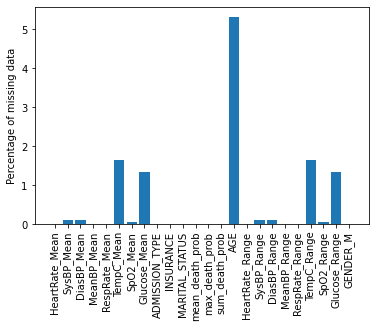

In [25]:
# Identifying Columns with Null variables
Nulls_train = X_train.isnull().sum()
print(Nulls_train)
# Filtering Columns with Null variables
missing_data_col= X_train.columns[Nulls_train>0]
print(missing_data_col)

# Plotting proportion of missing data
plt.xticks(rotation='vertical')
plt.bar(Nulls_train.index, 100*Nulls_train.values/len(X_train.index))
plt.ylabel('Percentage of missing data')
print(X_train.shape)

The percentage of missing values is at most 5%, which indicated that there are no columns that should be deleted.

HeartRate_Mean     545
SysBP_Mean         551
DiasBP_Mean        552
MeanBP_Mean        547
RespRate_Mean      546
TempC_Mean         638
SpO2_Mean          551
Glucose_Mean        58
ADMISSION_TYPE       0
INSURANCE            0
MARITAL_STATUS       0
mean_death_prob      0
max_death_prob       0
sum_death_prob       0
AGE                270
HeartRate_Range    545
SysBP_Range        551
DiasBP_Range       552
MeanBP_Range       547
RespRate_Range     546
TempC_Range        638
SpO2_Range         551
Glucose_Range       58
GENDER_M             0
dtype: int64
(5221, 24)


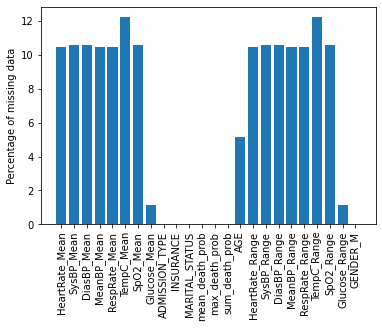

In [26]:
# Identifying Columns with Null variables
Nulls_test = X_test.isnull().sum()
print(Nulls_test)
# Filtering Columns with Null variables
missing_data_col= X_test.columns[Nulls_test>0]
missing_data_col

# Plotting proportion of missing data
plt.xticks(rotation='vertical')
plt.bar(Nulls_test.index, 100*Nulls_test.values/len(X_test.index))
plt.ylabel('Percentage of missing data')
print(X_test.shape)

The percentage of missing values is higher than in X_train, yet it is still below 20% which can be interpreted as a reasonable cutoff for including a column. Thus, I keep all variables.

### 2.3 Scaling the data with ```StandardScaler``` 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [27]:
# fit the scaler with training data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
#print(scaler.mean_) # optional: print column means

StandardScaler()

In [28]:
# Scale training and test data (with the mean and sd from train data!!)
X_train = scaler.transform(X_train) # result is a numpy.ndarray
X_test = scaler.transform(X_test)
#np.mean(Xs, axis=0) # Calculates column means (after scaling -> 0) 

# Change to panda dataframe and print stats
X_train = pd.DataFrame(X_train, columns= feature_names)
X_test = pd.DataFrame(X_test, columns= feature_names)
X_train.describe()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,mean_death_prob,max_death_prob,sum_death_prob,AGE,HeartRate_Range,SysBP_Range,DiasBP_Range,MeanBP_Range,RespRate_Range,TempC_Range,SpO2_Range,Glucose_Range,GENDER_M
count,1.869300e+04,1.867400e+04,1.867300e+04,1.869400e+04,1.869100e+04,1.838700e+04,1.868100e+04,1.844200e+04,1.869400e+04,1.869400e+04,1.869400e+04,1.869400e+04,1.869400e+04,1.869400e+04,1.770200e+04,1.869300e+04,1.867400e+04,1.867300e+04,1.869400e+04,1.869100e+04,1.838700e+04,1.868100e+04,1.844200e+04,1.869400e+04
mean,-3.702258e-16,3.764913e-16,1.918112e-16,-1.029840e-15,1.132260e-16,3.634804e-15,2.451358e-15,-3.902577e-16,-1.167498e-15,4.556107e-16,-1.077184e-16,-1.194793e-16,3.777514e-16,-1.311315e-17,-7.664064e-18,-2.693284e-16,7.152107e-17,1.288339e-16,6.030090e-17,-5.256794e-18,-1.879656e-17,6.481798e-17,-5.992838e-17,-9.051875e-16
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000028e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00
min,-3.294166e+00,-4.380087e+00,-4.135011e+00,-4.666217e+00,-2.518353e+00,-1.008484e+01,-2.108816e+01,-2.157274e+00,-2.493197e+00,-2.031643e+00,-1.153593e+00,-3.019361e+00,-1.966753e+00,-1.519302e+00,-2.041962e+00,-1.968599e+00,-2.449112e+00,-2.193858e+00,-1.683776e+00,-2.574746e+00,-1.587228e+00,-1.167905e+00,-8.490363e-01,-1.130403e+00
25%,-7.122285e-01,-7.213448e-01,-6.867949e-01,-6.816416e-01,-7.106166e-01,-6.014346e-01,-4.518878e-01,-6.312229e-01,4.094595e-01,-1.000236e+00,-9.019935e-01,-6.578272e-01,-6.883406e-01,-7.279747e-01,-7.496628e-01,-6.388761e-01,-6.828599e-01,-6.993881e-01,-5.896881e-01,-6.268722e-01,-6.911285e-01,-4.848275e-01,-6.107859e-01,-1.130403e+00
50%,-6.855641e-02,-1.344513e-01,-9.878509e-02,-1.182938e-01,-1.566433e-01,-3.365819e-02,1.183301e-01,-2.257776e-01,4.094595e-01,8.479521e-01,-2.121625e-02,-1.598820e-01,-2.317987e-01,-2.130336e-01,-2.401513e-02,-1.956350e-01,-1.488766e-01,-2.012315e-01,-2.249922e-01,-1.399037e-01,-1.790714e-01,-2.115964e-01,-2.534103e-01,8.846400e-01
75%,6.534931e-01,6.179047e-01,5.853909e-01,5.785451e-01,5.501926e-01,5.648089e-01,6.340873e-01,3.598656e-01,4.094595e-01,8.479521e-01,-2.121625e-02,5.016616e-01,3.882408e-01,4.769744e-01,7.730505e-01,4.692266e-01,5.083336e-01,4.961878e-01,2.723204e-01,5.093877e-01,5.250072e-01,1.982501e-01,2.555792e-01,8.846400e-01
max,5.136961e+00,4.971575e+00,5.358514e+00,5.313745e+00,5.780423e+00,5.778224e+00,1.342959e+00,1.425538e+01,4.094595e-01,1.222731e+00,4.106041e+00,1.260204e+01,4.530098e+00,5.754165e+00,1.969952e+00,8.558376e+00,8.559159e+00,1.026006e+01,7.964089e+00,7.651593e+00,2.571822e+01,1.235703e+01,2.425389e+01,8.846400e-01


### 2.4 Imputing missing values with the kNN Imputer 

I found that kNN imputing was a more accurate way of imputing means since it takes all other factors of an individual into account. For example, it replaces a value for a similar person in terms of age, vitals etc.

I found 100 neighbours to be valid since it will make larger groups but can still make fine distinctions.

In [29]:
from sklearn.impute import KNNImputer

imputer_knn = KNNImputer(n_neighbors= 200, weights = "distance").fit(X_train)
X_train = pd.DataFrame(imputer_knn.transform(X_train), columns= feature_names)
X_train.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,mean_death_prob,max_death_prob,sum_death_prob,AGE,HeartRate_Range,SysBP_Range,DiasBP_Range,MeanBP_Range,RespRate_Range,TempC_Range,SpO2_Range,Glucose_Range,GENDER_M
0,2.341080,-0.752118,-0.121529,-0.275846,0.873564,-1.112945,-0.483335,0.490009,0.409459,0.847952,-0.901994,-0.117633,-0.025166,0.053281,0.322648,1.134088,-0.272104,0.197294,-0.523380,-0.139904,0.525007,0.061635,0.439682,-1.130403
1,-0.395681,-0.743353,0.201867,-0.252760,-0.760283,-0.463327,0.939552,-0.811421,0.409459,-1.000236,-0.021216,-1.700158,-0.983677,-1.393136,-1.239684,0.635442,-1.134692,-0.948466,-0.821767,-1.276164,-1.267193,-0.894674,-0.849036,-1.130403
2,0.424973,-0.380934,-0.516980,-0.424754,-0.801545,-0.141075,1.342959,1.770733,0.409459,0.847952,-0.119907,0.845806,0.038448,0.205758,0.251231,-1.026712,-0.395330,-1.097913,-0.888076,-1.276164,-1.075171,-1.167905,1.468490,-1.130403
3,0.892839,-0.729003,-1.875879,-1.334182,2.022792,1.792434,-0.763403,-0.315877,-2.493197,0.847952,0.725319,-0.383061,-0.342540,-0.258653,0.695377,0.912468,-0.354255,0.745266,-0.158684,1.158679,2.061179,1.837636,-0.513320,-1.130403
4,0.833704,0.554932,1.114715,0.829049,-0.851603,-0.266030,0.862068,-0.779886,0.409459,-1.000236,-0.901994,-0.695141,-0.906741,-0.704264,-0.907616,1.355709,-0.477482,-0.799019,-0.755459,-0.464549,-0.499107,-0.621443,-0.307558,0.884640


In [30]:
X_test = pd.DataFrame(imputer_knn.transform(X_test), columns= feature_names)
X_test.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,mean_death_prob,max_death_prob,sum_death_prob,AGE,HeartRate_Range,SysBP_Range,DiasBP_Range,MeanBP_Range,RespRate_Range,TempC_Range,SpO2_Range,Glucose_Range,GENDER_M
0,-0.912180,2.231410,-0.236203,0.562712,2.075988,0.420563,-0.540714,-0.856470,0.409459,0.847952,-0.901994,-0.407110,-0.402697,-0.436706,1.519029,-0.528066,0.097577,0.147478,-0.059221,0.022419,-0.179071,0.334866,-0.697422,-1.130403
1,-0.227853,0.204820,-0.415843,-0.268493,0.190812,-0.179091,-0.517094,-0.315877,0.409459,0.847952,0.725319,0.844410,0.307145,-0.903431,1.260986,-0.002020,0.231215,0.204337,0.091953,-0.101967,-0.119751,0.216180,-0.849036,-1.130403
2,-1.328107,-0.275560,-1.739706,-1.598350,-0.032265,0.107519,-0.359615,1.370663,0.409459,-1.000236,-0.021216,0.548397,0.743590,1.324133,-0.024015,-0.749686,0.508334,0.147478,-0.390763,0.022419,-0.499107,0.471481,1.013649,0.884640
3,0.481849,-0.645597,-0.799917,-0.790341,-0.439997,0.159271,-0.012677,-0.262528,0.409459,-1.252904,-0.901994,1.062746,0.388241,0.823118,-1.445596,-1.026712,-0.806087,-1.097913,0.603862,-0.464549,0.005349,0.608097,0.244750,0.884640
4,0.596902,-0.482249,0.160792,-0.203824,0.531048,1.223262,-0.535406,-0.477304,0.409459,0.847952,-0.021216,-0.109753,-0.614360,-0.406229,0.322648,0.857063,-0.107801,-0.001969,-0.357609,0.509388,2.253200,-0.074981,-0.275069,0.884640


### 2.5 Plotting the Correlation Matrix

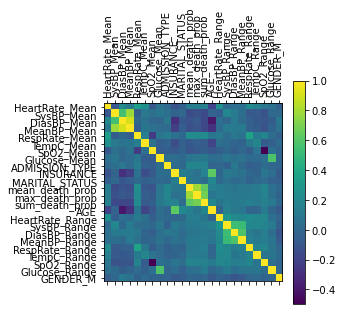

In [31]:
# Plot the correlation matrix to see which variables are correlated
import matplotlib.pyplot as plt

plt.matshow(X_train.corr())
plt.colorbar()
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=90)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.show()

The vitals that capture blood pressure are highly correlated. Yet, when I reduced the number of corresponding variables, the accuracy decreased. I beleive that having all is important as it puts weight on the blood pressure, which seems to be an important determinant of the proability of dying.

The summary statistics for the death probability from the meta data are also highly correlated. Still, I chose not to reduce the variables as that would decrease the weight on this highly important feature.

## 3. SVM Model

## 3.1 Hyperparameter Tuning using GridSearchCV
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

I searched over 'rbf', 'linear', 'poly' kernels and found that the Radial basis function kernel produced the highest cross-validated AUC score. To reduce computation time I proceeded to only search over different values for the Cost function and Gamma. Further, I adjusted for imbalanced classes with SMOTE but found no improvement of the score, so I decided to with the argument class_weight='balanced' in the SVC function.

In [32]:
# Grid Search over both Linear and Non-Linear
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# mod_svc = SVC(probability = False, max_iter = 500)
# grid_values = {'kernel' : ['rbf', 'linear', 'poly'], # Different Kernels
#                'C' : [1.2, 2, 4, 12, 15], # Different values for the cost function
#                'gamma' : ['scale', 'auto', 0.25, 0.5, 0.75]} # Different values for gamma
# grid_svc_acc = GridSearchCV(mod_svc, param_grid = grid_values, 
#                             scoring = 'roc_auc' , cv = 5, n_jobs = 8) # Scoring with accuracy for faster computation

In [33]:
# Grid Search Non-Linear
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

mod_svc = SVC(class_weight='balanced', kernel = "rbf", probability = True, max_iter = 10000)
grid_values = {'C' : [0.5, 1, 2], # Different values for the cost function
               'gamma' : ['auto', 0.25]} # Different values for gamma
grid_svc_acc = GridSearchCV(mod_svc, param_grid = grid_values, 
                            scoring = 'roc_auc' , cv = 10, n_jobs = 16) # Scoring with accuracy for faster computation

In [34]:
# Fit the model
grid_svc_acc.fit(X_train, y_train)

/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/

/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jonaswallstein/opt/anaconda3/

GridSearchCV(cv=10,
             estimator=SVC(class_weight='balanced', max_iter=10000,
                           probability=True),
             n_jobs=16, param_grid={'C': [0.5, 1, 2], 'gamma': ['auto', 0.25]},
             scoring='roc_auc')

### 3.2 Results of GridSearchCV

Best gamma parameter : auto
Best Cost parameter : 0.5
best parameters: {'C': 0.5, 'gamma': 'auto'}
best score:      0.95088 (+/-0.00569)


,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.5,auto,"{'C': 0.5, 'gamma': 'auto'}",0.945336,0.954062,0.947547,0.954527,0.950602,0.950058,0.959630,0.945290,0.942238,0.959552,0.950884,0.005690,1
2,1,auto,"{'C': 1, 'gamma': 'auto'}",0.943425,0.952318,0.946520,0.952008,0.948458,0.947175,0.957586,0.943624,0.941445,0.956428,0.948899,0.005250,2
4,2,auto,"{'C': 2, 'gamma': 'auto'}",0.940557,0.949071,0.944062,0.948155,0.945057,0.942417,0.953418,0.939998,0.939459,0.952502,0.945470,0.004842,3
1,0.5,0.25,"{'C': 0.5, 'gamma': 0.25}",0.918480,0.919346,0.915866,0.917840,0.924486,0.925307,0.924511,0.916432,0.904842,0.935453,0.920256,0.007575,4
3,1,0.25,"{'C': 1, 'gamma': 0.25}",0.917117,0.918032,0.915485,0.916994,0.919453,0.921825,0.923243,0.915323,0.903413,0.932841,0.918373,0.007009,5
5,2,0.25,"{'C': 2, 'gamma': 0.25}",0.915634,0.916285,0.915347,0.917103,0.916236,0.918902,0.924047,0.911354,0.898132,0.931121,0.916416,0.008018,6


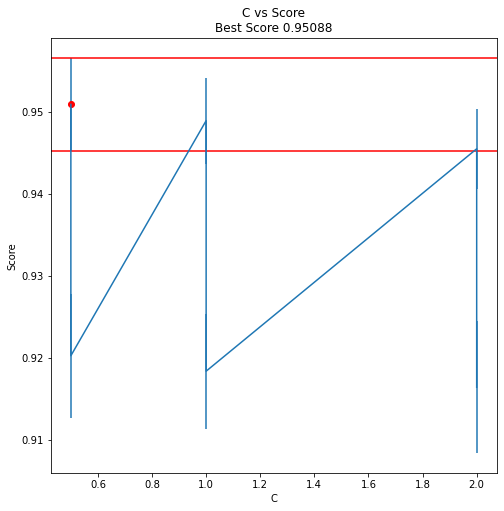

In [35]:
# Report best C
best_C = grid_svc_acc.best_estimator_.C
best_gamma = grid_svc_acc.best_estimator_.gamma
print('Best gamma parameter : '+ str(best_gamma))
print('Best Cost parameter : '+ str(best_C))
GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)

In [36]:
# Printing best score
print(grid_svc_acc.best_score_)

0.9508841751146762


### 3.3 Predictions
Reweighing to account for bias due to oversampling. Since q1 = 0.55 is quite close to the default of 0.5, the result does not change much.

In [41]:
# the correction factor: 
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

In [48]:
q1 = ((y_train+1)/2).sum()/len(y_train)
r1 = 0.5
q1

0.556007275061517

In [46]:
y_pred_acc = pd.Series(grid_svc_acc.predict_proba(X_test)[:,1]).apply(reweight, args=(q1,r1))

## 4. Exporting to csv

In [47]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_pred_acc})
test_predictions_submit.to_csv("../svm/test_predictions_submit.csv", index = False)